# 作業 : (Kaggle)鐵達尼生存預測
https://www.kaggle.com/c/titanic

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

data_path = 'data/'
df_train = pd.read_csv(data_path + 'titanic_train.csv')
df_test = pd.read_csv(data_path + 'titanic_test.csv')

train_Y = df_train['Survived']
ids = df_test['PassengerId']
df_train = df_train.drop(['PassengerId', 'Survived'] , axis=1)
df_test = df_test.drop(['PassengerId'] , axis=1)
df = pd.concat([df_train,df_test])
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

5 Numeric Features : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']



- Pclass:Ticket class艙等
- Age:Age in years 乘客年齡
- SibSp:# of siblings / spouses aboard the Titanic 兄弟姊妹/配偶數
- Parch:# of parents / children aboard the Titanic 父母/小孩數
- Fare:Passenger fare 乘客票價

In [3]:
# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
train_num = train_Y.shape[0]
df.head()

,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


In [4]:
df.describe()

,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,29.881138,0.498854,0.385027,33.295479
std,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,80.000000,8.000000,9.000000,512.329200


In [5]:
df.isnull().sum().sort_values()

Pclass      0
SibSp       0
Parch       0
Fare        1
Age       263
dtype: int64

> 空值只有Fare & Age
- Fare應該與Pclass有關
- Age可以填平均數或眾數

In [6]:
# groupby Pclass
subdf_Pclass = df.groupby('Pclass')
subdf_Pclass['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,323.0,87.508992,80.447178,0.0,30.6958,60.0000,107.6625,512.3292
2,277.0,21.179196,13.607122,0.0,13.0000,15.0458,26.0000,73.5000
3,708.0,13.302889,11.494358,0.0,7.7500,8.0500,15.2458,69.5500


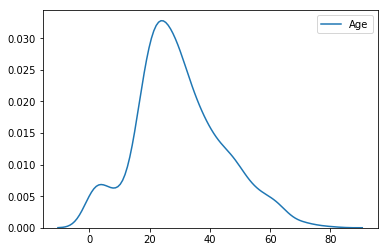

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(df['Age'])

> 有點偏態可以試試填補中位數是否比平均數好

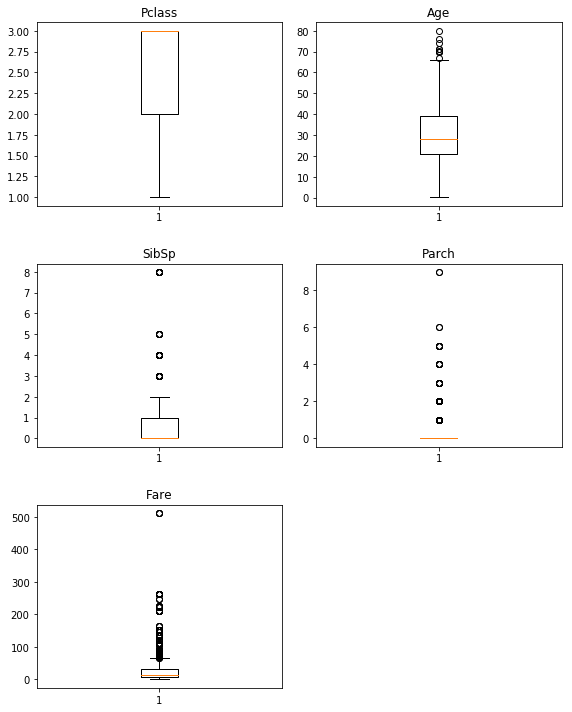

In [9]:
# 箱型圖檢查極端值
plt.figure(figsize=(8,10))
for i in range(len(num_features)):
    plt.subplot(3,2,i+1)
    plt.boxplot(df[num_features[i]][~df[num_features[i]].isnull()])
    plt.title(str(num_features[i]))
plt.tight_layout(h_pad = 2.5)
plt.show()

In [10]:
df[df['Fare'].isnull().values==True]

,Pclass,Age,SibSp,Parch,Fare
152,3,60.5,0,0,NaN


In [11]:
df.iloc[152:153]

,Pclass,Age,SibSp,Parch,Fare
152,3,55.5,0,0,8.05


# 作業1
* 試著在補空值區塊, 替換並執行兩種以上填補的缺值, 看看何者比較好?

In [12]:
# 空值補 -1, 做羅吉斯迴歸
df_m1 = df.fillna(-1)
train_X = df_m1[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.6960299128976762

In [13]:
# 空值補 0, 做羅吉斯迴歸
df_0 = df.fillna(0)
train_X = df_0[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator,train_X,train_Y, cv = 5).mean()

0.6971535084032942

In [14]:
# 空值補 mean, 做羅吉斯迴歸
df_mn = df.fillna(df.mean())
train_X = df_mn[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator,train_X,train_Y, cv=5).mean()

0.6981761033723469

In [15]:
# 空值補 median, 做羅吉斯迴歸
df_q50 = df.fillna(df.median())
train_X = df_q50[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator,train_X,train_Y, cv=5).mean()

0.6992934218081011

> 結論:填中位數效果較好

# 作業2
* 使用不同的標準化方式 ( 原值 / 最小最大化 / 標準化 )，搭配羅吉斯迴歸模型，何者效果最好?

In [16]:
# 空值補 中位數, 搭配最大最小化
df_q50 = df.fillna(df.median())
df_q50_MM = MinMaxScaler().fit_transform(df_q50)
train_X = df_q50_MM[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator,train_X,train_Y, cv=5).mean()

D:\ProgramData\Anaconda3\envs\ML_DAY100\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


0.6982328807104934

In [17]:
# 空值補 中位數, 搭配標準化
df_q50_SS = StandardScaler().fit_transform(df_q50)
train_X = df_q50_SS[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator,train_X,train_Y, cv=5).mean()

D:\ProgramData\Anaconda3\envs\ML_DAY100\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\ProgramData\Anaconda3\envs\ML_DAY100\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0.6970587140092496

> 結論:最大最小化效果比較好，但有許多極端值為什麼不是標準化結果較好?